In [1]:
pip install ib_insync

In [179]:
from ib_insync import *

ib = IB()

await ib.connectAsync('127.0.0.1', 7497, clientId=1)
print("Connected to Interactive Brokers API")


Connected to Interactive Brokers API


In [180]:
from ib_insync import *
import pytz
import pandas as pd

contract = Future('ES', '202406', 'CME')
await ib.qualifyContractsAsync(contract)

historical_data = await ib.reqHistoricalDataAsync(
    contract, endDateTime='', durationStr='30 D',
    barSizeSetting='1 hour', whatToShow='MIDPOINT', useRTH=True
)

tz = pytz.timezone('US/Eastern')
for bar in historical_data:
    bar.date = bar.date.astimezone(tz)

df = pd.DataFrame([vars(bar) for bar in historical_data])

print(df)

                         date     open     high      low    close  volume  \
0   2024-03-22 09:30:00-04:00  5301.00  5304.75  5294.00  5297.75    -1.0   
1   2024-03-22 10:00:00-04:00  5297.75  5303.25  5289.75  5290.50    -1.0   
2   2024-03-22 11:00:00-04:00  5290.50  5298.25  5289.75  5296.75    -1.0   
3   2024-03-22 12:00:00-04:00  5296.75  5299.00  5289.25  5298.25    -1.0   
4   2024-03-22 13:00:00-04:00  5298.25  5306.00  5297.25  5305.50    -1.0   
..                        ...      ...      ...      ...      ...     ...   
232 2024-05-03 09:30:00-04:00  5153.25  5161.75  5137.25  5157.25    -1.0   
233 2024-05-03 10:00:00-04:00  5157.25  5166.75  5127.50  5133.00    -1.0   
234 2024-05-03 11:00:00-04:00  5133.00  5150.75  5126.50  5146.25    -1.0   
235 2024-05-03 12:00:00-04:00  5146.25  5155.75  5145.50  5148.75    -1.0   
236 2024-05-03 13:00:00-04:00  5148.75  5155.50  5147.25  5154.25    -1.0   

     average  barCount  
0       -1.0        -1  
1       -1.0        -1  


In [15]:
!pip install nest_asyncio

In [187]:
#Model construction and training
import nest_asyncio
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
nest_asyncio.apply()
class LSTMModel():
    # Model initialization
    def __init__(self, sequence_size=60, lstm_units=50, dense_units=25, drop_out_rates=0.2):
        self.sequence_size = sequence_size
        self.lstm_units = lstm_units
        self.dense_units = dense_units
        self.drop_out_rates = drop_out_rates
        self.model = None
    # Preprocess data for model training
    def preprocess_data(self,filepath):
        data = pd.read_csv(filepath)
        features = data[['close', 'high', 'low', 'volume']].values # Fetch 4 columns from dataframe
        scaler = MinMaxScaler(feature_range=(0, 1))# Initialize scaler and normalize data to a range of 0 to 1.
        scaled_features = scaler.fit_transform(features)# Scaling each feature to the range (0,1) depending on the values 
        return scaled_features, scaler

    # Create sequences for LSTM training
    def create_sequences(self,data):
        inputSequence = [] #initialize input sequence
        targetSequence = [] #initialize target sequence
        sequenceFormationLength = len(data) - self.sequence_size;
        for i in range(sequenceFormationLength): # iteration of data to form sequence    
            inputSequence.append(data[i:(i + self.sequence_size)]) # Appending a piece of data from i to i + sequence_size
            targetSequence.append(data[i + self.sequence_size, 0])# Used for prediction of the future close price
        return np.array(inputSequence), np.array(targetSequence)
    # Construct LSTM model 
    def build_lstm_model(self,input_shape):
        lstmLayerWithSequence = LSTM(self.lstm_units, return_sequences=True, input_shape=input_shape)
        self.model = Sequential([
            lstmLayerWithSequence, # LSTM layer with 50 neurons and returning full sequence which passed into the next layer as an input
            Dropout(self.drop_out_rates), # Dropout layer added to prevent overfitting
            LSTM(self.lstm_units), # Only the last output of the output sequence is returned and reduce dimensionality
            Dropout(self.drop_out_rates), # Dropout layer added to prevent overfitting
            Dense(self.dense_units), # Fully-connected layer with 25 neurons that process the features fetched by the recurrent layers through interpretation and process of the output of prediction.
            Dense(1) # Fully-connected layer with 1 neuron that outputs the predicted value
        ])
        self.model.compile(optimizer='adam', loss='mean_squared_error') # Compile with Adam optimizer and configured the model for training
    # Plotting model learning
    def plot_model_learning(self, history):
        plt.figure(figsize=(11, 6))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        plt.show()
    # Inverse transform futures' prices
    def inverse_transform_price(self, scaler, prices, feature_array): 
        feature_array[:, 0] = prices # Assign the price in the column where close price is stored
        return scaler.inverse_transform(feature_array)[:, 0]# Column for close price transformed
    # Plot predictions
    def plot_predictions(self, actual, predicted):
        plt.figure(figsize=(11, 6))
        plt.plot(actual, label='Actual Price', color='blue')
        plt.plot(predicted, label='Predicted Price', color='red')
        plt.title('Actual vs Predicted Prices')
        plt.xlabel('Time')
        plt.ylabel('Price')
        plt.legend()
        plt.show()
    # Preprocess security data
    def preprocess_security_data(self, data, filename):
        data.to_csv(filename, index=False)
    # Model makes prediction
    def predict(self, data):
        return self.model.predict(data)
    # Train model
    def train(self, inputs, targets, validation_data, epochs=10, batch_size=32):
        return self.model.fit(inputs, targets, epochs=epochs, batch_size=batch_size, validation_data=validation_data)
    

In [190]:
# Prediction
def predict_security_price(model, scaler, data, current_price):
    scaled_data = data.reshape(1, -1, 4)  # Reshape scaled data passed into LSTM model as an input
    scaled_prediction = model.predict(scaled_data)  # Model makes prediction based on scaled data
    features = np.zeros((1, 4))# Use 4 features as per scaler fitting, one row and four columns, which correspond to the 4 features
    features[0, 0] = scaled_prediction[0][0]# Predicted price goes into the position of close price
    predicted_price = scaler.inverse_transform(features)[0, 0]# Inverse transform and fetch the close price, the scaled prediction is converted back to the original scale of the data
    return predicted_price, current_price

#Making trade decision based on predicted price and current price
def trade_decision(predicted_price, current_price, available_funds, current_shares):
    transaction_fee = 2.25
    available_funds = float(available_funds)
    decision = "HOLD"
    shares = 0
    price_elastic_buffer = current_price * (0.5 / 100)# Readjust the price price difference between predicted price and actual price by a ratio of 0.5% of actual price 
    if predicted_price + price_elastic_buffer > current_price and available_funds > transaction_fee and available_funds / current_price >= 50:
        if (available_funds - transaction_fee)/ current_price >= 50:
            decision = "BUY"
            shares = 1
    elif predicted_price + price_elastic_buffer < current_price and current_shares > 0:
        decision = "SELL"
        shares = 1
        
    return decision, shares, predicted_price

2024-05-03 13:29:35.587690: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-03 13:29:35.589026: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-03 13:29:35.590362: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2024-05-03 13:29:35.789664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_1_grad/concat/split_1/split_dim' with dtype int32
	 [[{{node gradients/split_1_grad/concat/split_1/split_dim}}]]
2024-05-03 13:29:36.072283: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-03 13:29:36.073678: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT:

6/6 [==============================] - ETA: 0s - loss: 0.1597

2024-05-03 13:29:39.158023: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-03 13:29:39.159325: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-03 13:29:39.160522: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6/6 [==============================] - 4s 159ms/step - loss: 0.1597 - val_loss: 0.0288
Epoch 2/50
6/6 [==============================] - 0s 30ms/step - loss: 0.0494 - val_loss: 0.0101
Epoch 3/50
6/6 [==============================] - 0s 37ms/step - loss: 0.0271 - val_loss: 0.0239
Epoch 4/50
6/6 [==============================] - 0s 34ms/step - loss: 0.0253 - val_loss: 0.0101
Epoch 5/50
6/6 [==============================] - 0s 34ms/step - loss: 0.0197 - val_loss: 0.0125
Epoch 6/50
6/6 [==============================] - 0s 31ms/step - loss: 0.0181 - val_loss: 0.0091
Epoch 7/50
6/6 [==============================] - 0s 33ms/step - loss: 0.0166 - val_loss: 0.0106
Epoch 8/50
6/6 [==============================] - 0s 32ms/step - loss: 0.0136 - val_loss: 0.0090
Epoch 9/50
6/6 [==============================] - 0s 35ms/step - loss: 0.0140 - val_loss: 0.0100
Epoch 10/50
6/6 [==============================] - 0s 31ms/step - loss: 0.0124 - val_loss: 0.0093
Epoch 11/50
6/6 [======================

2024-05-03 13:29:49.286977: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-03 13:29:49.288454: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-03 13:29:49.289997: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 8ms/step


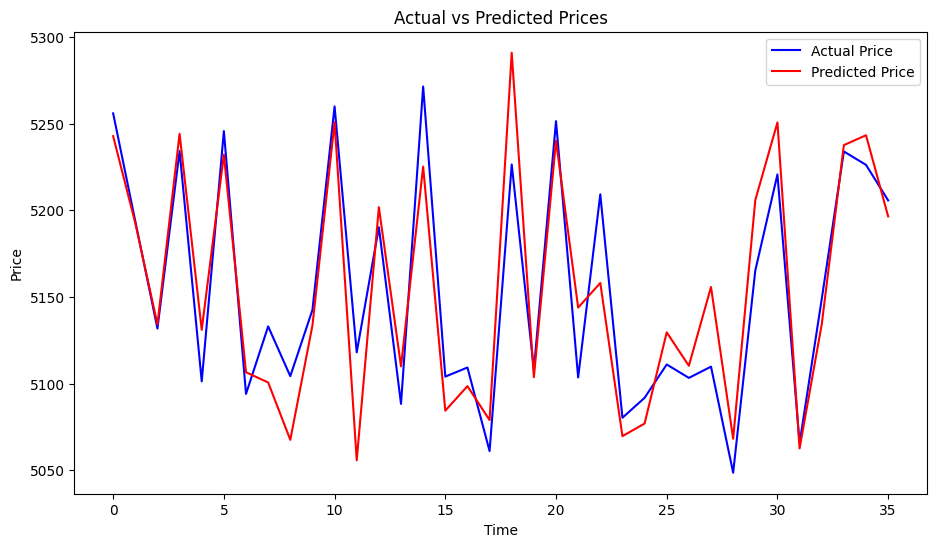

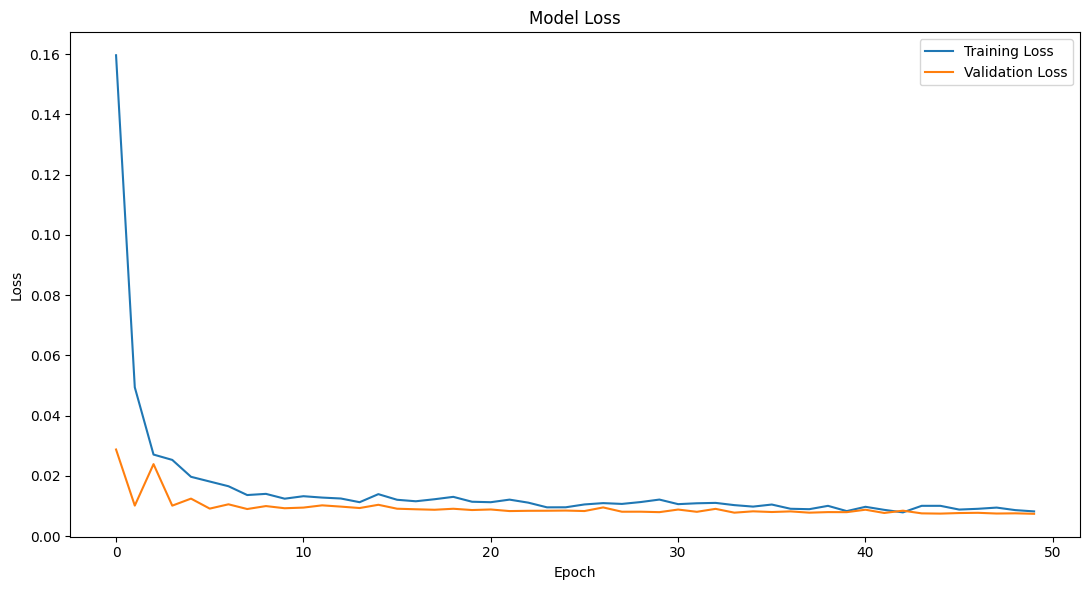

In [188]:
# Fetching current price
async def fetchCurrentPrice():
    #Fetching price for every trading hour
    historical_data = await ib.reqHistoricalDataAsync(
        contract, endDateTime='', durationStr='30 D',
        barSizeSetting='1 hour', whatToShow='MIDPOINT', useRTH=True
    )

    tz = pytz.timezone('US/Eastern')
    for bar in historical_data:
        bar.date = bar.date.astimezone(tz)

    df = pd.DataFrame([vars(bar) for bar in historical_data])
    price = historical_data[len(historical_data)-1].close
    return price


# Model building and plotting model performance indicators
def build_model():
    model = LSTMModel(sequence_size=60, lstm_units=50, dense_units=25)
    model.preprocess_security_data(df, 'ib_es500_price_history.csv')
    features = ['close', 'high', 'low', 'volume']
    scaled_features, scaler = model.preprocess_data(filepath)
    inputs, targets = model.create_sequences(scaled_features)
    x_train, x_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.2, random_state=42)
    input_shape = x_train.shape[1], x_train.shape[2]
    model.build_lstm_model(input_shape)
    history = model.train(inputs, targets, (x_test, y_test), epochs=50, batch_size=32)
    predicted_scaled = model.predict(x_test)
    array_predicted = np.zeros((len(predicted_scaled.flatten()), 4))
    array_actual = np.zeros((len(y_test), 4))
    predicted_prices = model.inverse_transform_price(scaler, predicted_scaled.flatten(), array_predicted)
    actual_prices = model.inverse_transform_price(scaler, y_test, array_actual)
    model.plot_predictions(actual_prices, predicted_prices)
    model.plot_model_learning(history)
build_model()

In [191]:
# Price prediction and execution of trade decision
def fetchMostRecentData():
    model.preprocess_and_save_data(df, 'ib_es500_price_history.csv')
    filepath = 'ib_es500_price_history.csv'
    scaled_features, scaler = model.preprocess_data(filepath)
    return scaled_features
# Execute price prediction
async def execute_prediction():
    positions = ib.positions()
    current_shares = 0
    for pos in positions:
        if pos.contract.symbol == 'ES' and pos.contract.secType == 'FUT':
            current_shares = pos.position     
    account_summary = await ib.accountSummaryAsync()
    balance = next((item for item in account_summary if item.tag == 'TotalCashBalance'), None)
    available_funds = balance.value
    contract = Future('ES', '202406', 'CME')
    util.sleep(5)
    current_price = await fetchCurrentPrice()
    total_cost = current_shares * current_price  # Simulated total cost of current shares
    recent_data = fetchMostRecentData()[-60:]  # most recent 60 prices used for prediction
    predicted_price, current_price = predict_security_price(model, scaler, recent_data, current_price)
    decision, shares, predicted_price = trade_decision(predicted_price, current_price, available_funds, current_shares)
    
    return decision, shares, predicted_price, current_price
# Execute trade decision
def execute_trade_decision(decision, shares, predicted_price, current_price):
    print(f"Current price: {current_price}. Predicted price: {predicted_price}")
    if decision == "BUY":
        order = MarketOrder('BUY', shares)
        ib.placeOrder(contract, order)
        print(f"Trade decision: {decision}")
        print(f"Request to {decision} {shares} shares has been completed.")
    elif decision == "SELL":
        print(f"Trade decision: {decision}")
        order = MarketOrder('SELL', shares)
        ib.placeOrder(contract, order)
        print(f"Request to {decision} {shares} shares has been completed.")
    elif decision == "HOLD":
        print(f"Trade decision: {decision}")
        print("Request to HOLD, no trade action.")
decision, shares, predicted_price, current_price = await execute_prediction()
execute_trade_decision(decision, shares, predicted_price, current_price)

1/1 [==============================] - 0s 24ms/step
Current price: 5152.5. Predicted price: 5131.662051133812
Trade decision: BUY
Request to BUY 1 shares has been completed.
